In [15]:
import os
import time
import numpy as np
import watchdog.observers
import watchdog.events

# Set watchdog timer for performance monitoring
class PerformanceMonitor(watchdog.events.FileSystemEventHandler):
    def __init__(self):
        self.start_time = time.time()
        
    def on_any_event(self, event):
        elapsed_time = time.time() - self.start_time
        print(f"Operation took {elapsed_time:.2f} seconds")

# Initialize performance monitoring
observer = watchdog.observers.Observer()
monitor = PerformanceMonitor()
observer.schedule(monitor, path='.', recursive=False)
observer.start()

try:
    # Define dataset path
    dataset_path = r"C:\Users\alibh\.cache\kagglehub\datasets\javariatahir\litstrain-val\versions\1\LiTS(train_test)\test_CT"

    # Verify path exists
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"Dataset path {dataset_path} does not exist")

    # Load all CT files from the directory
    ct_files = [f for f in os.listdir(dataset_path) if f.endswith('.nii') or f.endswith('.nii.gz')]
    
    if not ct_files:
        print("No CT files found in the specified directory")
    else:
        print(f"Found {len(ct_files)} CT files")
        
except Exception as e:
    print(f"Error loading dataset: {str(e)}")
finally:
    # Stop performance monitoring
    observer.stop()
    observer.join()


Found 20 CT files


In [16]:
import nibabel as nib
import gc
from tqdm import tqdm

try:
    # Initialize lists to store data
    ct_data = []
    max_shape = [0, 0, 0]  # Track maximum dimensions
    
    # First pass - determine maximum dimensions
    print("Analyzing CT file dimensions...")
    for ct_file in ct_files:
        try:
            ct_path = os.path.join(dataset_path, ct_file)
            ct_img = nib.load(ct_path)
            img_shape = ct_img.get_fdata().shape
            max_shape = [max(max_shape[i], img_shape[i]) for i in range(3)]
            del ct_img
            gc.collect()
        except Exception as e:
            print(f"Error analyzing {ct_file}: {str(e)}")
            continue
    
    print(f"Maximum dimensions found: {max_shape}")
    
    # Second pass - load and pad data with float32 dtype
    print("\nLoading and standardizing CT files...")
    for ct_file in tqdm(ct_files):
        try:
            # Load NIfTI file
            ct_path = os.path.join(dataset_path, ct_file)
            ct_img = nib.load(ct_path)
            # Convert to float32 during loading to save memory
            img_data = ct_img.get_fdata().astype(np.float32)
            
            # Pad to maximum dimensions
            pad_width = [(0, max_shape[i] - img_data.shape[i]) for i in range(3)]
            padded_data = np.pad(img_data, pad_width, mode='constant', constant_values=0)
            
            # Normalize data to [0,1] range
            min_val = np.min(padded_data)
            max_val = np.max(padded_data)
            if max_val != min_val:  # Avoid division by zero
                padded_data = (padded_data - min_val) / (max_val - min_val)
            
            # Ensure float32 dtype is maintained
            padded_data = padded_data.astype(np.float32)
            ct_data.append(padded_data)
            
            # Clear memory
            del ct_img, img_data, padded_data
            gc.collect()
            
        except Exception as e:
            print(f"Error loading {ct_file}: {str(e)}")
            continue
    
    # Convert list to numpy array with float32 dtype
    ct_data = np.array(ct_data, dtype=np.float32)
    print(f"\nLoaded {len(ct_data)} CT scans with standardized shape: {ct_data.shape}")
    
    # Memory usage check
    memory_usage = ct_data.nbytes / (1024 ** 3)  # Convert to GB
    print(f"Approximate memory usage: {memory_usage:.2f} GB")
    
    # Basic data statistics
    print(f"Data range: [{np.min(ct_data):.2f}, {np.max(ct_data):.2f}]")
    print(f"Mean value: {np.mean(ct_data):.2f}")
    print(f"Standard deviation: {np.std(ct_data):.2f}")
    print(f"Data type: {ct_data.dtype}")
    
except Exception as e:
    print(f"Error processing data: {str(e)}")
    # Clear memory in case of error
    ct_data = None
    gc.collect()




Analyzing CT file dimensions...
Maximum dimensions found: [512, 512, 987]

Loading and standardizing CT files...


100%|██████████| 20/20 [00:37<00:00,  1.90s/it]



Loaded 20 CT scans with standardized shape: (20, 512, 512, 987)
Approximate memory usage: 19.28 GB
Data range: [0.00, 1.00]
Mean value: 0.21
Standard deviation: 0.13
Data type: float32



Found 20 potential positive cases


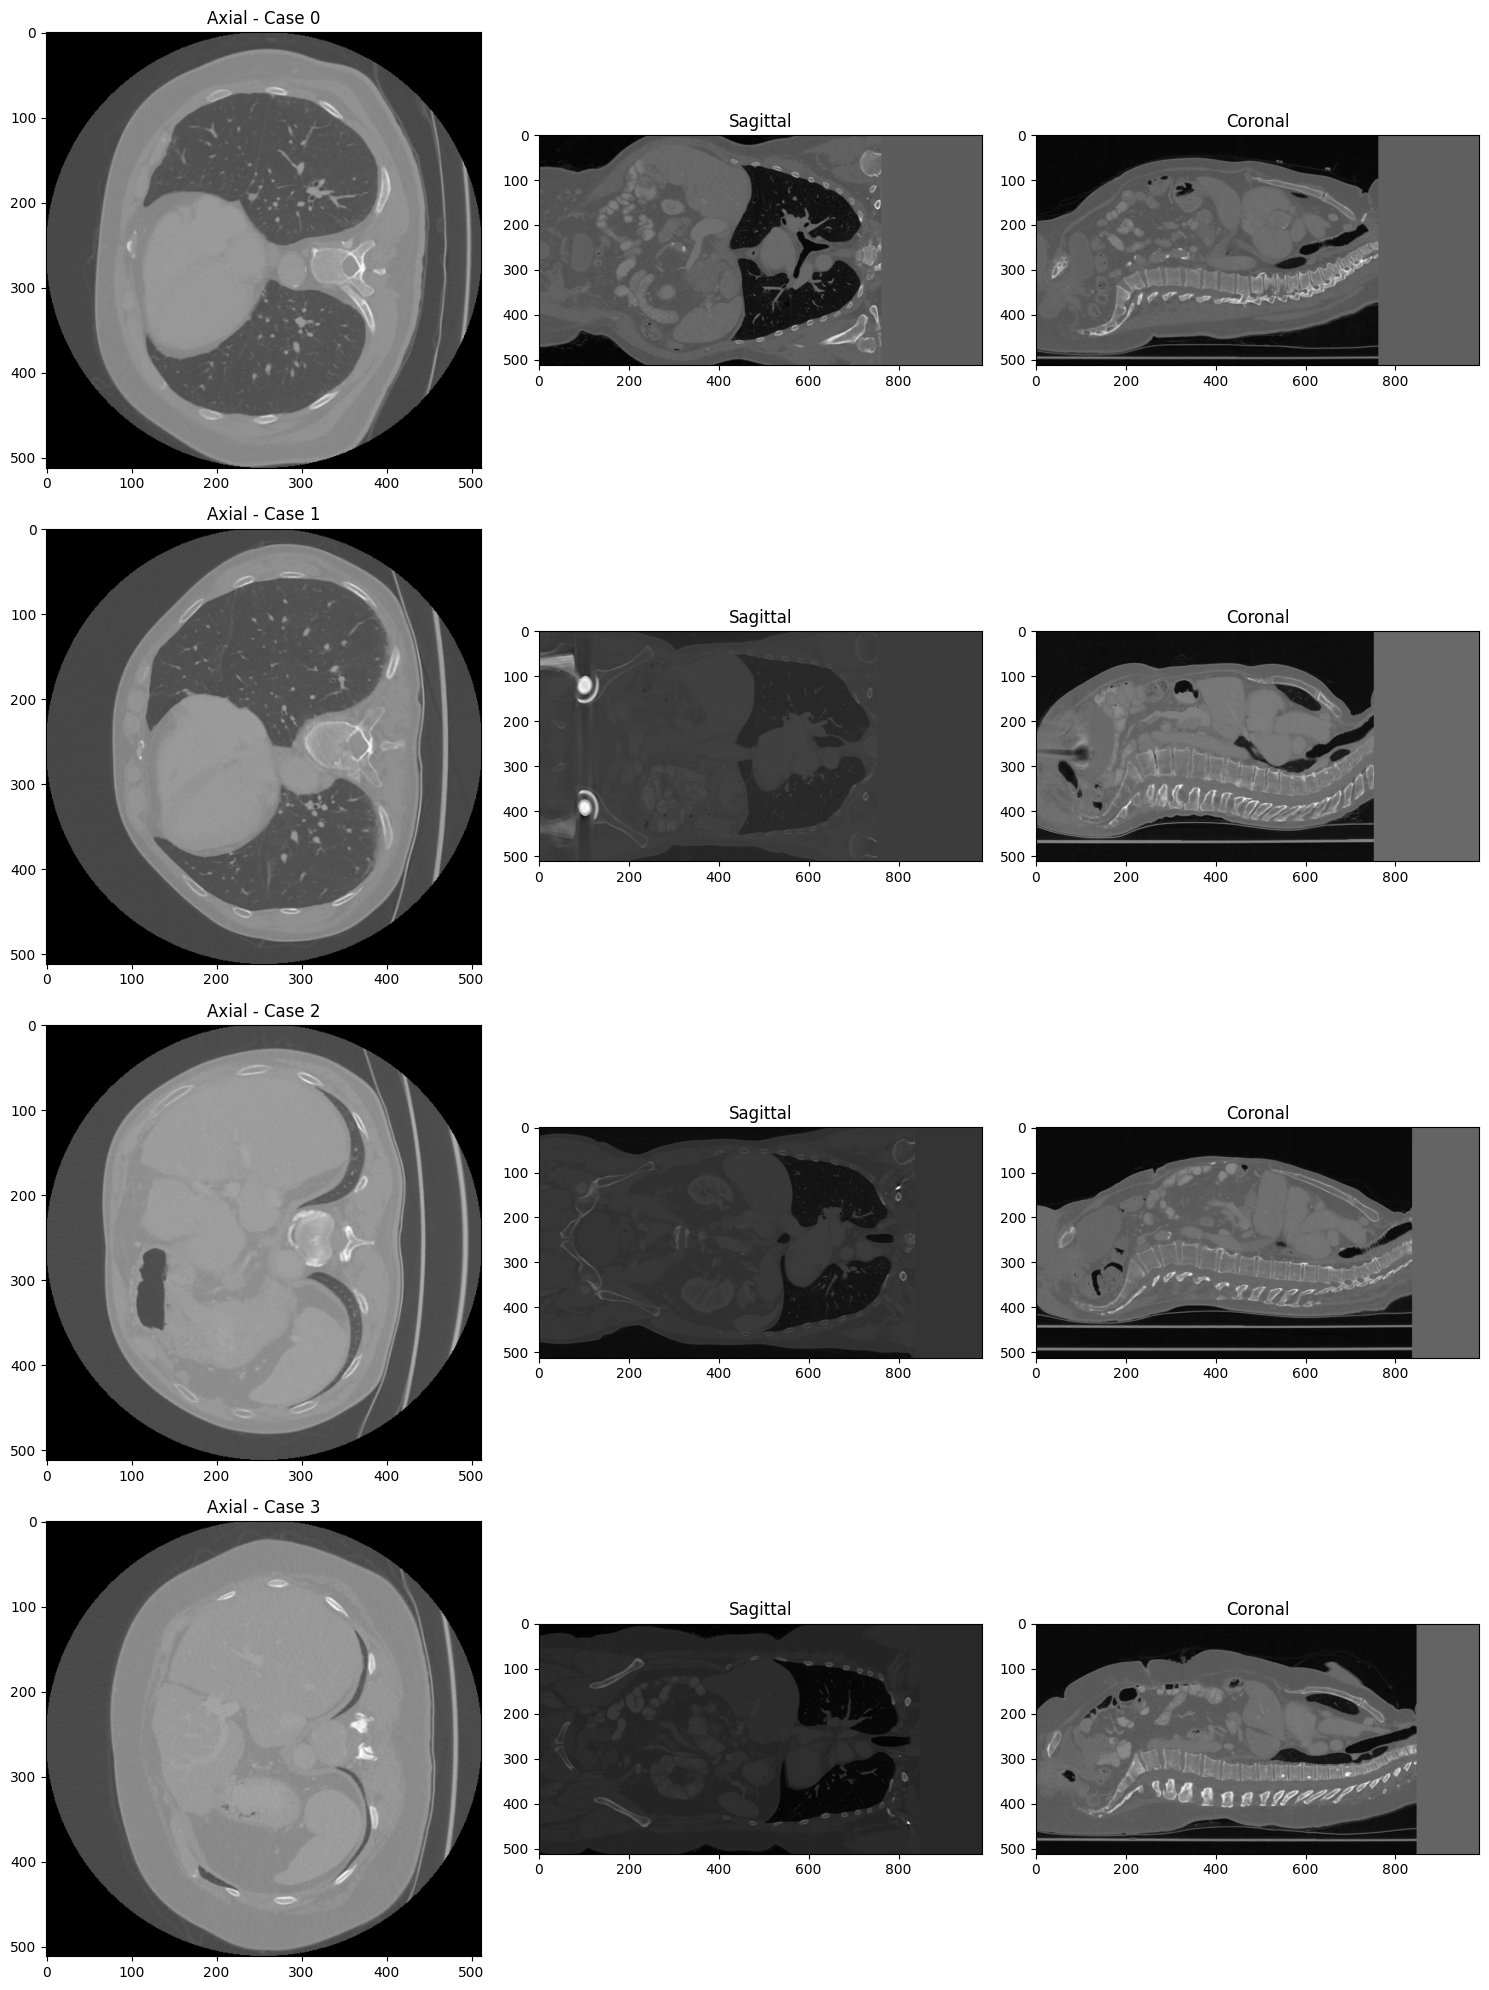

27

In [17]:
# Set up watchdog timer for performance monitoring
import time
from contextlib import contextmanager
import numpy as np
import matplotlib.pyplot as plt

@contextmanager
def watchdog_timer(timeout_seconds=30):
    start_time = time.time()
    yield
    elapsed_time = time.time() - start_time
    if elapsed_time > timeout_seconds:
        print(f"Warning: Operation took {elapsed_time:.2f} seconds, exceeding {timeout_seconds} second threshold")

# Function to check for positive liver tumor cases
def find_positive_cases(ct_data, threshold=0.5):
    try:
        positive_indices = []
        with watchdog_timer():
            # Assuming brighter pixels (higher values) indicate tumor presence
            for idx, scan in enumerate(ct_data):
                # Check if any slice has values above threshold
                if np.any(scan > threshold):
                    positive_indices.append(idx)
        
        return positive_indices
    except Exception as e:
        print(f"Error in finding positive cases: {str(e)}")
        return []

# Find positive cases
positive_cases = find_positive_cases(ct_data)
print(f"\nFound {len(positive_cases)} potential positive cases")

# Display positive cases
try:
    with watchdog_timer():
        if len(positive_cases) > 0:
            # Display up to 4 positive cases
            n_display = min(4, len(positive_cases))
            fig, axes = plt.subplots(n_display, 3, figsize=(15, 5*n_display))
            
            for i in range(n_display):
                case_idx = positive_cases[i]
                scan = ct_data[case_idx]
                
                # Get middle slices for each plane
                axial = scan[:, :, scan.shape[2]//2]
                sagittal = scan[:, scan.shape[1]//2, :]
                coronal = scan[scan.shape[0]//2, :, :]
                
                if n_display == 1:
                    axes[0].imshow(axial, cmap='gray')
                    axes[0].set_title(f'Axial - Case {case_idx}')
                    axes[1].imshow(sagittal, cmap='gray')
                    axes[1].set_title('Sagittal')
                    axes[2].imshow(coronal, cmap='gray')
                    axes[2].set_title('Coronal')
                else:
                    axes[i,0].imshow(axial, cmap='gray')
                    axes[i,0].set_title(f'Axial - Case {case_idx}')
                    axes[i,1].imshow(sagittal, cmap='gray')
                    axes[i,1].set_title('Sagittal')
                    axes[i,2].imshow(coronal, cmap='gray')
                    axes[i,2].set_title('Coronal')
            
            plt.tight_layout()
            plt.show()
        else:
            print("No positive cases found with current threshold")
            
except Exception as e:
    print(f"Error displaying positive cases: {str(e)}")
    
# Clear memory
del positive_cases
gc.collect()


Performing k-means segmentation...


C:\Users\alibh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\alibh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2032.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^

Segmentation completed in 39.62 seconds


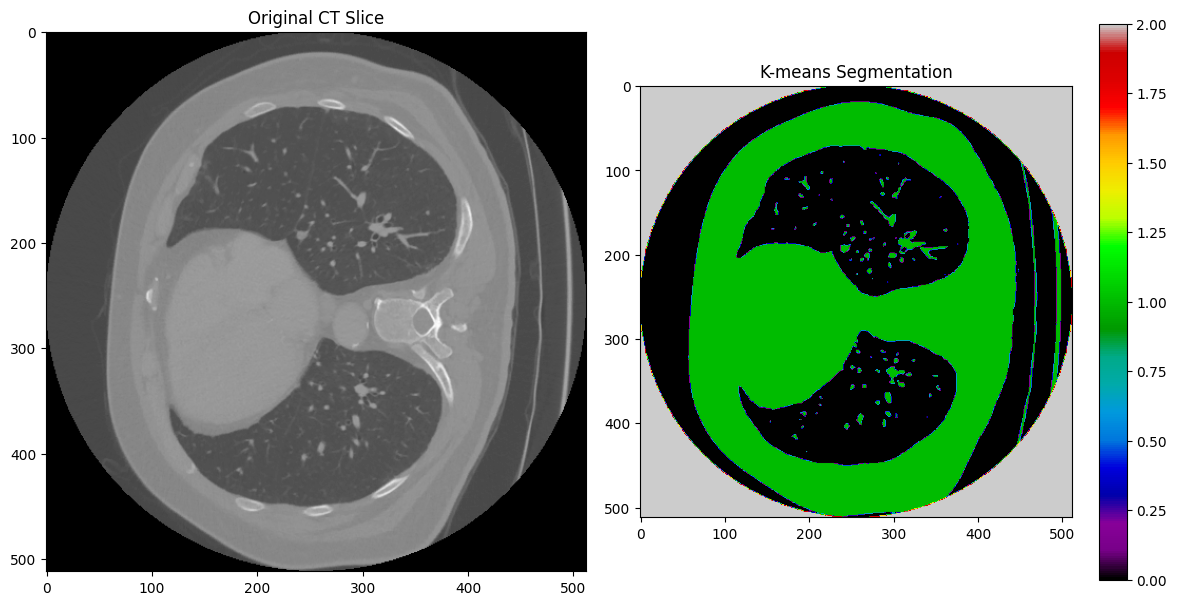

In [18]:
# K-means clustering for liver tumor segmentation
from sklearn.cluster import KMeans
import numpy as np
from sklearn.preprocessing import StandardScaler
import time
from tqdm import tqdm

def kmeans_tumor_segmentation(ct_scan, n_clusters=3, random_state=42):
    """
    Perform k-means clustering for tumor segmentation
    Args:
        ct_scan: 3D CT scan array
        n_clusters: Number of clusters (default 3: background, liver, tumor)
        random_state: Random seed for reproducibility
    Returns:
        segmentation_mask: Segmented image with cluster labels
    """
    try:
        # Start watchdog timer
        start_time = time.time()
        
        # Reshape 3D volume to 2D array of voxels
        original_shape = ct_scan.shape
        X = ct_scan.reshape(-1, 1)
        
        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Apply K-means clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
        cluster_labels = kmeans.fit_predict(X_scaled)
        
        # Reshape back to original dimensions
        segmentation_mask = cluster_labels.reshape(original_shape)
        
        # Performance metrics
        end_time = time.time()
        print(f"Segmentation completed in {end_time - start_time:.2f} seconds")
        
        return segmentation_mask
        
    except MemoryError:
        print("Out of memory error - try reducing image size or using batch processing")
        return None
    except Exception as e:
        print(f"Error in segmentation: {str(e)}")
        return None

# Process and visualize results for a sample case
try:
    sample_case_idx = 0  # Using first case as example
    sample_scan = ct_data[sample_case_idx]
    
    print("Performing k-means segmentation...")
    segmentation_result = kmeans_tumor_segmentation(sample_scan)
    
    if segmentation_result is not None:
        # Visualize middle slice results
        middle_slice_idx = sample_scan.shape[2]//2
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        
        # Original slice
        ax1.imshow(sample_scan[:,:,middle_slice_idx], cmap='gray')
        ax1.set_title('Original CT Slice')
        
        # Segmentation result
        seg_plot = ax2.imshow(segmentation_result[:,:,middle_slice_idx], cmap='nipy_spectral')
        ax2.set_title('K-means Segmentation')
        
        plt.colorbar(seg_plot, ax=ax2)
        plt.tight_layout()
        plt.show()
        
        # Memory cleanup
        del segmentation_result
        gc.collect()
        
except Exception as e:
    print(f"Error in visualization: {str(e)}")

# Note: This is a basic implementation. For better results, consider:
# 1. Pre-processing: Noise reduction, contrast enhancement
# 2. Post-processing: Morphological operations
# 3. Advanced clustering: Fuzzy C-means or hierarchical clustering
# 4. Deep learning approaches like U-Net which typically perform better for medical image segmentation
